<a href="https://colab.research.google.com/github/Atomix77/IMLO-IP/blob/main/IMLO_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data



In [6]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.optim import lr_scheduler

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

trainingTransform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(180),
    transforms.RandomAutocontrast(),
    transforms.RandomAdjustSharpness(1.5, 0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    ])

validationTransform = transforms.Compose([ 
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),
    ])

testTransform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),
    ])

trainingData = datasets.Flowers102(
    root = "./datasets",
    split = "train",
    transform = trainingTransform,
    download = True)

validationData = datasets.Flowers102(
    root = "./datasets",
    split = "val",
    transform = validationTransform,
    download = True)

testData = datasets.Flowers102(
    root = "./datasets",
    split = "test",
    transform = testTransform,
    download = True)

# Dataloaders

In [7]:
trainingDataloader = DataLoader(trainingData, batch_size = 8, shuffle = True, num_workers = 6)
validationDataloader = DataLoader(validationData, batch_size = 32, shuffle = False, num_workers = 6)
testDataloader = DataLoader(testData, batch_size = 32, shuffle = False, num_workers = 6)

# Display Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labeles: tensor([80, 76, 94, 17, 15, 74])


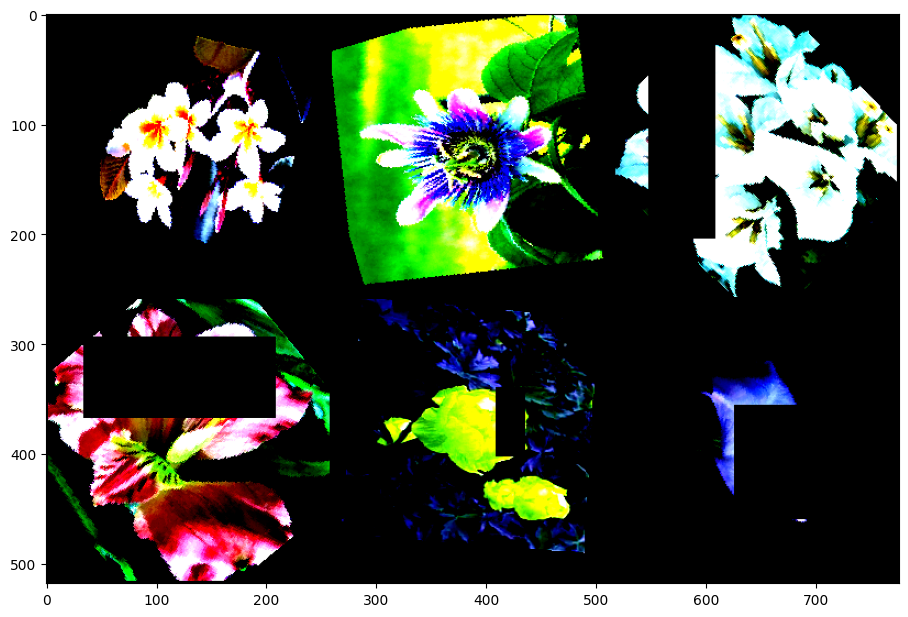

In [8]:
def displayImages(dataset):
    loader = DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    grid = make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labeles:', labels)

displayImages(trainingData)

# Get device

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Create Aritecture

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, classAmount):
        super(NeuralNetwork, self).__init__()
        self.convStack =  nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),          

            nn.Conv2d(64, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 256, 3, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, 3, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Dropout(0.5)
        )

        dummyInput = torch.zeros(1, 3, 256, 256)
        dummyOutput = self.convStack(dummyInput)
        self.convOutputSize = dummyOutput.view(1, -1).size(1)
        print(self.convOutputSize)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.convOutputSize, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),

            nn.Linear(2048, 1024),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.ReLU(),
            
            nn.Linear(512, classAmount)
        )
    

    def forward(self, x):
        x = self.convStack(x)
        x = self.classifier(x)
        return x

model = NeuralNetwork(102).to(device)

512


# Train Model

In [11]:
losses = []
accuracy = []
def trainModel(dataloader, model, lossFunction, optimizer):
    model.train()
    currentLoss = 0.0
    correct = 0
    total = 0
    epochLoss = 0
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        total += y.size(0)

        optimizer.zero_grad()
        pred = model(X)
        loss = lossFunction(pred, y)
        loss.backward()
        optimizer.step()

        currentLoss += loss.item()
        epochLoss += lossFunction(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    epochLoss = epochLoss/total
    correct = correct/total

    losses.append(epochLoss)
    accuracy.append(correct * 100)
    print(f'Training: Accuracy {correct * 100:>0.1f}%, Loss: {currentLoss / len(dataloader):.5f}, Epoch Loss: {epochLoss:.5f}')

# Validate Model

In [12]:
def validateModel(dataloader, model, lossFunction):
    model.eval()
    total = 0
    correct = 0
    epochLoss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total += y.size(0)
            epochLoss += lossFunction(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    epochLoss = epochLoss/total
    correct = (correct/total) * 100

    print(f"Validation: Accuracy: {(correct):>0.1f}%, Avg loss: {epochLoss:>8f} \n")
    return epochLoss, correct

# Test Model

In [13]:
def testModel(dataloader, model, lossFunction):
    model.eval()
    total = 0
    correct = 0
    testLoss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total += y.size(0)
            testLoss += lossFunction(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    testLoss = testLoss/total
    correct = (correct/total) * 100
    print(f"Testing: Accuracy: {(correct):>0.1f}%, Avg loss: {testLoss:>8f} \n")
    return testLoss, correct

# Model Evaluation

In [14]:
learningRate = 0.0001
weightDecay = 0.0001
epochs = 1000

bestValAccuracy = 0.0
bestValLoss = float('inf')
bestEpoch = 0

valLosses = []
valAccuracies = []

lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=450, gamma=0.99)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')
    trainModel(trainingDataloader, model, lossFunction, optimizer)
    valLoss, valAccuracy = validateModel(validationDataloader, model, lossFunction)
    valLosses.append(valLoss)
    valAccuracies.append(valAccuracy)
    scheduler.step()

    if (valLoss < bestValLoss):
        bestValLoss = valLoss
        bestValAccuracy = valAccuracy
        bestEpoch = epoch+1

testModel(testDataloader, model, lossFunction)
print(f'Best Accuracy: {bestValAccuracy}. Best Loss: {bestValLoss} Best Epoch: {bestEpoch}')
print("Finished")

# Save model
torch.save(model.state_dict(),'bestModel.pt')

Epoch 1:
Training: Accuracy 1.5%, Loss: 4.79052, Epoch Loss: 0.60116
Validation: Accuracy: 3.2%, Avg loss: 0.144059 

Epoch 2:
Training: Accuracy 1.3%, Loss: 4.72152, Epoch Loss: 0.59250
Validation: Accuracy: 1.5%, Avg loss: 0.143541 

Epoch 3:
Training: Accuracy 1.0%, Loss: 4.72737, Epoch Loss: 0.59324
Validation: Accuracy: 2.1%, Avg loss: 0.141272 

Epoch 4:
Training: Accuracy 2.1%, Loss: 4.61173, Epoch Loss: 0.57873
Validation: Accuracy: 2.4%, Avg loss: 0.139156 

Epoch 5:
Training: Accuracy 1.7%, Loss: 4.56965, Epoch Loss: 0.57345
Validation: Accuracy: 2.8%, Avg loss: 0.136954 

Epoch 6:
Training: Accuracy 1.6%, Loss: 4.49082, Epoch Loss: 0.56355
Validation: Accuracy: 2.1%, Avg loss: 0.136780 

Epoch 7:
Training: Accuracy 3.1%, Loss: 4.45186, Epoch Loss: 0.55866
Validation: Accuracy: 3.7%, Avg loss: 0.132183 

Epoch 8:
Training: Accuracy 1.7%, Loss: 4.44088, Epoch Loss: 0.55729
Validation: Accuracy: 4.1%, Avg loss: 0.131295 

Epoch 9:
Training: Accuracy 2.5%, Loss: 4.37656, Epoch L

Testing: Accuracy: 75.2%, Avg loss: 0.032671 - 1000 epochs (434 mins - 7 hrs 12 mins)

Testing: Accuracy: 73.9%, Avg loss: 0.034663 - 1000 epochs (416 mins - 6 hrs 55 mins)

Testing: Accuracy: 72.8%, Avg loss: 0.036552 - 1000 epochs (426 mins - 7 hrs 6 mins)

Testing: Accuracy: 66.2%, Avg loss: 0.041491 - 1000 epochs (619 mins - 10 hrs 20 mins)

Testing: Accuracy 62.7% Avg loss: 0.053697 - 500 epochs (3hrs 30 mins)

Testing: Accuracy: 66.4%, Avg loss: 0.044697 - 500 epochs (3hrs 30 mins)

Testing: Accuracy: 59.3%, Avg loss: 0.060451 - 500 epochs (3 hrs 25 mins)- potentially done with 350 epochs. 

Testing: Accuracy: 48.1%, Avg loss: 0.069918  - 200 epochs

Testing: Accuracy: 48.5%, Avg loss: 0.063186 - 200 epochs

# Graph

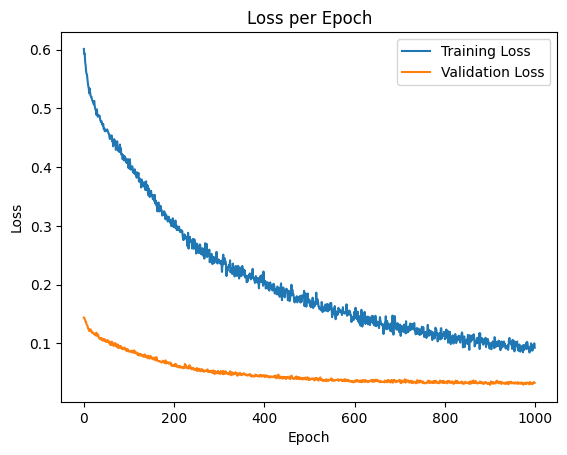

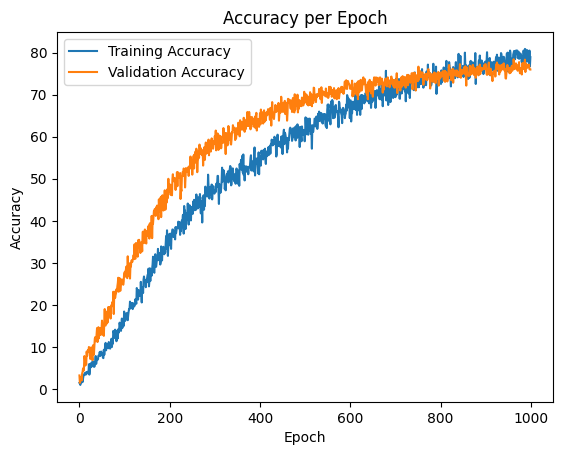

In [15]:
# Plot the loss values
plt.plot(range(epochs), losses)
plt.plot(range(epochs), valLosses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

plt.plot(range(epochs), accuracy)
plt.plot(range(epochs), valAccuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Load and Test the trained model

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

testTransform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)),
    ])

testData = datasets.Flowers102(
    root = "./datasets",
    split = "test",
    transform = testTransform,
    download = True)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self, classAmount):
        super(NeuralNetwork, self).__init__()
        self.convStack =  nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(32, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),          

            nn.Conv2d(64, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, 3, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 256, 3, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, 3, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Dropout(0.5)
        )

        dummyInput = torch.zeros(1, 3, 256, 256)
        dummyOutput = self.convStack(dummyInput)
        self.convOutputSize = dummyOutput.view(1, -1).size(1)
        print(self.convOutputSize)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.convOutputSize, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),

            nn.Linear(2048, 1024),
            nn.Dropout(0.5),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.ReLU(),
            
            nn.Linear(512, classAmount)
        )
    

    def forward(self, x):
        x = self.convStack(x)
        x = self.classifier(x)
        return x

newModel = NeuralNetwork(102).to(device)

newModel.load_state_dict(torch.load('bestModel.pt', map_location=torch.device('cpu')))
newModel.eval()

def testTrainedModel(dataloader, model, lossFunction):
    model.eval()
    total = 0
    correct = 0
    testLoss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total += y.size(0)
            testLoss += lossFunction(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    testLoss = testLoss/total
    correct = (correct/total)  * 100
    print(f"Testing: Accuracy: {(correct):>0.1f}%, Avg loss: {testLoss:>8f} \n")

testDataloader = DataLoader(testData, batch_size = 32, shuffle = False, num_workers = 6)
lossFunction = nn.CrossEntropyLoss()

testTrainedModel(testDataloader, newModel, lossFunction)

Using cpu device
512
Testing: Accuracy: 73.9%, Avg loss: 0.034648 

